# Build a classification model: Delicious Asian and Indian Cuisines

## Cuisine classifiers 1

In this lesson, we'll explore a variety of classifiers to *predict a given national cuisine based on a group of ingredients.* While doing so, we'll learn more about some of the ways that algorithms can be leveraged for classification tasks.

### [**Pre-lecture quiz**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Preparation**

This lesson builds up on our [previous lesson](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) where we:

-   Made a gentle introduction to classifications using a dataset about all the brilliant cuisines of Asia and India 😋.

-   Explored some [dplyr verbs](https://dplyr.tidyverse.org/) to prep and clean our data.

-   Made beautiful visualizations using ggplot2.

-   Demonstrated how to deal with imbalanced data by preprocessing it using [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrated how to `prep` and `bake` our recipe to confirm that it will work as supposed to.

#### **Prerequisite**

For this lesson, we'll require the following packages to clean, prep and visualize our data:

-   `tidyverse`: The [tidyverse](https://www.tidyverse.org/) is a [collection of R packages](https://www.tidyverse.org/packages) designed to makes data science faster, easier and more fun!

-   `tidymodels`: The [tidymodels](https://www.tidymodels.org/) framework is a [collection of packages](https://www.tidymodels.org/packages/) for modeling and machine learning.


-   `themis`: The [themis package](https://themis.tidymodels.org/) provides Extra Recipes Steps for Dealing with Unbalanced Data.

-   `nnet`: The [nnet package](https://cran.r-project.org/web/packages/nnet/nnet.pdf) provides functions for estimating feed-forward neural networks with a single hidden layer, and for multinomial logistic regression models.

You can have them installed as:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternatively, the script below checks whether you have the packages required to complete this module and installs them for you in case they are missing.

In [1]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



Now, let's hit the ground running!

## 1. Split the data into training and test sets.

We'll start by picking a few steps from our previous lesson.

### Drop the most common ingredients that create confusion between distinct cuisines, using `dplyr::select()`.

Everyone loves rice, garlic and ginger!


In [2]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
• `` -> `...1`
Rows: 2448 Columns: 385
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


Perfect! Now, time to split the data such that 70% of the data goes to training and 30% goes to testing. We'll also apply a `stratification` technique when splitting the data to `maintain the proportion of each cuisine` in the training and validation datasets.

[rsample](https://rsample.tidymodels.org/), a package in Tidymodels, provides infrastructure for efficient data splitting and resampling:

In [3]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. Deal with imbalanced data

As you might have noticed in the original data set as well as in our training set, there is quite an unequal distribution in the number of cuisines. Korean cuisines are *almost* 3 times Thai cuisines. Imbalanced data often has negative effects on the model performance. Many models perform best when the number of observations is equal and, thus, tend to struggle with unbalanced data.

There are majorly two ways of dealing with imbalanced data sets:

-   adding observations to the minority class: `Over-sampling` e.g using a SMOTE algorithm which synthetically generates new examples of the minority class using nearest neighbors of these cases.

-   removing observations from majority class: `Under-sampling`

In our previous lesson, we demonstrated how to deal with imbalanced data sets using a `recipe`. A recipe can be thought of as a blueprint that describes what steps should be applied to a data set in order to get it ready for data analysis. In our case, we want to have an equal distribution in the number of our cuisines for our `training set`. Let's get right into it.

In [4]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

You can of course go ahead and confirm (using prep+bake) that the recipe will work as you expect it - all the cuisine labels having `559` observations.

Since we'll be using this recipe as a preprocessor for modeling, a `workflow()` will do all the prep and bake for us, so we won't have to manually estimate the recipe.

Now we are ready to train a model 👩‍💻👨‍💻!

## 3. Choosing your classifier

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Artwork by @allison_horst</figcaption>


Now we have to decide which algorithm to use for the job 🤔.

In Tidymodels, the [`parsnip package`](https://parsnip.tidymodels.org/index.html) provides consistent interface for working with models across different engines (packages). Please see the parsnip documentation to explore [model types & engines](https://www.tidymodels.org/find/parsnip/#models) and their corresponding [model arguments](https://www.tidymodels.org/find/parsnip/#model-args). The variety is quite bewildering at first sight. For instance, the following methods all include classification techniques:

-   C5.0 Rule-Based Classification Models

-   Flexible Discriminant Models

-   Linear Discriminant Models

-   Regularized Discriminant Models

-   Logistic Regression Models

-   Multinomial Regression Models

-   Naive Bayes Models

-   Support Vector Machines

-   Nearest Neighbors

-   Decision Trees

-   Ensemble methods

-   Neural Networks

The list goes on!

### **What classifier to go with?**

So, which classifier should you choose? Often, running through several and looking for a good result is a way to test.

> AutoML solves this problem neatly by running these comparisons in the cloud, allowing you to choose the best algorithm for your data. Try it [here](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Also the choice of classifier depends on our problem. For instance, when the outcome can be categorized into `more than two classes`, like in our case, you must use a `multiclass classification algorithm` as opposed to `binary classification.`

### **A better approach**

A better way than wildly guessing, however, is to follow the ideas on this downloadable [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Here, we discover that, for our multiclass problem, we have some choices:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>A section of Microsoft's Algorithm Cheat Sheet, detailing multiclass classification options</figcaption>



### **Reasoning**

Let's see if we can reason our way through different approaches given the constraints we have:

-   **Deep Neural networks are too heavy**. Given our clean, but minimal dataset, and the fact that we are running training locally via notebooks, deep neural networks are too heavyweight for this task.

-   **No two-class classifier**. We do not use a two-class classifier, so that rules out one-vs-all.

-   **Decision tree or logistic regression could work**. A decision tree might work, or multinomial regression/multiclass logistic regression for multiclass data.

-   **Multiclass Boosted Decision Trees solve a different problem**. The multiclass boosted decision tree is most suitable for nonparametric tasks, e.g. tasks designed to build rankings, so it is not useful for us.

Also, normally before embarking on more complex machine learning models e.g ensemble methods, it's a good idea to build the simplest possible model to get an idea of what is going on. So for this lesson, we'll start with a `multinomial regression` model.

> Logistic regression is a technique used when the outcome variable is categorical (or nominal). For Binary logistic regression the number of outcome variables is two, whereas the number of outcome variables for multinomial logistic regression is more than two. See [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) for further reading.

## 4. Train and evaluate a Multinomial logistic regression model.

In Tidymodels, `parsnip::multinom_reg()`, defines a model that uses linear predictors to predict multiclass data using the multinomial distribution. See `?multinom_reg()` for the different ways/engines you can use to fit this model.

For this example, we'll fit a Multinomial regression model via the default [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) engine.

> I picked a value for `penalty` sort of randomly. There are better ways to choose this value that is, by using `resampling` and `tuning` the model which we'll discuss later.
>
> See [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) in case you want to learn more on how to tune model hyperparameters.

In [5]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Great job 🥳! Now that we have a recipe and a model specification, we need to find a way of bundling them together into an object that will first preprocess the data then fit the model on the preprocessed data and also allow for potential post-processing activities. In Tidymodels, this convenient object is called a [`workflow`](https://workflows.tidymodels.org/) and conveniently holds your modeling components! This is what we'd call *pipelines* in *Python*.

So let's bundle everything up into a workflow!📦

In [6]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! A **`workflow()`** can be fit in much the same way a model can. So, time to train a model!

In [7]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

The output shows the coefficients that the model learned during training.

### Evaluate the Trained Model

It's time to see how the model performed 📏 by evaluating it on a test set! Let's begin by making predictions on the test set.

In [8]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


Great job! In Tidymodels, evaluating model performance can be done using [yardstick](https://yardstick.tidymodels.org/) - a package used to measure the effectiveness of models using performance metrics. As we did in our logistic regression lesson, let's begin by computing a confusion matrix.

In [9]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map, like this:

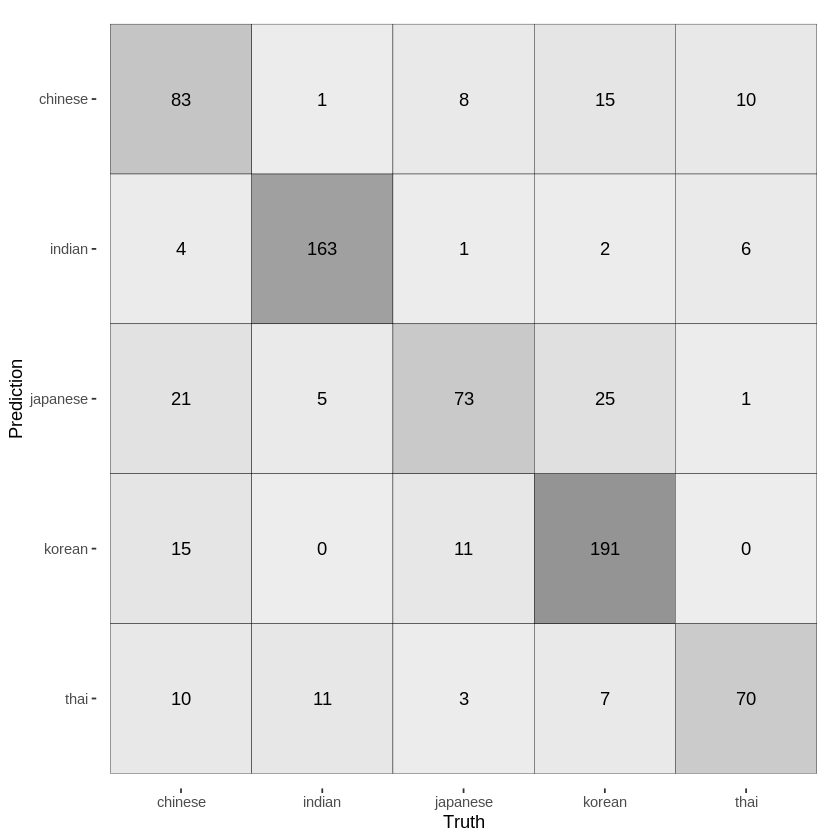

In [10]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

Let's now calculate summary statistics for the confusion matrix.

In [11]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


If we narrow down to some metrics such as accuracy, sensitivity, ppv, we are not badly off for a start 🥳!

## 4. Digging Deeper

Let's ask one subtle question: What criteria is used to settle for a given type of cuisine as the predicted outcome?

Well, Statistical machine learning algorithms, like logistic regression, are based on `probability`; so what actually gets predicted by a classifier is a probability distribution over a set of possible outcomes. The class with the highest probability is then chosen as the most likely outcome for the given observations.

Let's see this in action by making both hard class predictions and probabilities.

In [12]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


Much better!

✅ Can you explain why the model is pretty sure that the first observation is Thai?

## **🚀Challenge**

In this lesson, you used your cleaned data to build a machine learning model that can predict a national cuisine based on a series of ingredients. Take some time to read through the [many options](https://www.tidymodels.org/find/parsnip/#models) Tidymodels provides to classify data and [other ways](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) to fit multinomial regression.

#### THANK YOU TO:

[`Allison Horst`](https://twitter.com/allison_horst/) for creating the amazing illustrations that make R more welcoming and engaging. Find more illustrations at her [gallery](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) and [Jen Looper](https://www.twitter.com/jenlooper) for creating the original Python version of this module ♥️

<br>
Would have thrown in some jokes but I donut understand food puns 😅.

<br>

Happy Learning,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.
